# Machine Learning Examples
#### See Machine Learning Notes Notebook for More Info

## scikit-learn and the iris data
- Supervised Learning
- Classification

In [101]:
# import packages
from sklearn import datasets
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, normalize
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multiclass import OneVsRestClassifier
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# RandomizedSearchCV works just like GridSearchCV with syntax
# it uses less memory because it doesn't evaluate every single combination of hyperparameters
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# set default plotting
plt.style.use('ggplot')

## General Notes
- Split data to separate the labels and the data
```python
# splitting data to remove the target variables and convert to numpy array
x = df.drop('Target_variable', axis=1).values
y = df.Target_variable.values
```

- Pipelines can simplify code
    - output of a step is the input for the next step
    - each step is a tuple `('name', object implementing .fit() .transform() methods)`
- Can add interactions between features to a model
    - `interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)`
        - `interaction_only=True` means don't multiply a column by itself
        - `include_bias` allows you to include a bias term
            - y value when x is 0 (y intercept if linear model)
    - `interaction.fit_transform(x)` where x is the feature data
    - does not work with sparse matrices
- Hashing Trick
    - increases memory efficiency, especially with lots of features (i.e. when adding interaction features)
        - useful on large datasets
    - set a max number of hashes (columns in 'feature' array) to map to
        - some features will map to the same column, but oddly this has little effect on model accuracy
    - for bag-o-words, use `HashingVectorizer` instead of `CountVectorizer`
        - add extra args so we can do a straight substitute for CountVectorizer
            `norm=None, non_negative=True`

### Preprocessing Data for scikit-learn

#### Categorical Data
- for categorical data with n different options, create n new columns and use binary data 0/1 to denote which category an observation has
    - it is possible to eliminate one of the categories, since if an observation is 0 for all of the other categories, then it will be the missing one
        - if you don't do this, you are duplicating some information, which might be an issue for some models
- how to do this
    - can do this manually using `.map()`
    - use sklearn `OneHotEncoder()`
    - use pandas `get_dummies(drop_first=True)`

In [2]:
# example of transforming the data this way
df = pd.DataFrame({'Sex': ['M', 'F', 'F', 'M', 'M', 'F', 'F'], 
                   'Color': ['blue', 'red', 'yellow', 'blue', 'yellow', 'blue', 'blue'],
                   'Age': [1, 2, 3, 4, 5, 6, 7]})
df

,Sex,Color,Age
0,M,blue,1
1,F,red,2
2,F,yellow,3
3,M,blue,4
4,M,yellow,5
5,F,blue,6
6,F,blue,7


In [3]:
df_dum = pd.get_dummies(df, drop_first=True)
df_dum

,Age,Sex_M,Color_red,Color_yellow
0,1,1,0,0
1,2,0,1,0
2,3,0,0,1
3,4,1,0,0
4,5,1,0,1
5,6,0,0,0
6,7,0,0,0


#### Missing Values
- can drop the rows entirely
- usually not preferred to drop a column (feature) entirely
- if too much data would be lost, can impute (make an educated guess) for missing values
    - ex. use the mean of all non-missing entries and fill the missing values using sklearn imputer

In [4]:
df = pd.DataFrame({'values': [0, 1, 2, 1, np.nan, 1, 2, 0, np.nan]})
df

,values
0,0.0
1,1.0
2,2.0
3,1.0
4,NaN
5,1.0
6,2.0
7,0.0
8,NaN


In [5]:
# using SimpleImputer, axis=0 means to calculate the mean of the column
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = df['values'].values
x = x.reshape(-1, 1)
imp.fit(x)
x = imp.transform(x)

In [6]:
x

array([[0.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [2.],
       [0.],
       [1.]])

Imputing with a pipeline
```python
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
logreg = linear_model.LogisticRegression()
steps = [('imputation', imp), ('logistic_regression', logreg)]
pipeline = Pipeline(steps)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)
```

#### Centering and Scaling Data (Normalizing)
- Standardization: subtract by mean and divide by variance
- Other methods as well
- sklearn's StandardScaler object will standardize
    - StandardScaler considers all of the features together (i.e. removing the mean/variance)
    - Normalizer does each feature independently
- can add to a pipeline

```python
# can use x_scaled(data) on the current dataset or on new test data or other unseen data
from sklearn.preprocessing import StandardScaler
x_scaled = StandardScaler(x)


# in a pipeline for k-nn classifiers
steps = [('scaler': StandardScaler()),
         ('knn': KNeighborsClassifer())]
pipeline = Pipeline(steps)


# cross validation and scaling in a pipeline with k-nn
steps = [('scaler': StandardScaler()),
         ('knn': KNeighborsClassifer())]
pipeline = Pipeline(steps)

# value of the knn__n_neighbors var is a list or array of values to try (for k here)
parameters = {knn__n_neighbors=np.arange(1, 50)}

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(x_train, y_train)
y_pred = cv.predict(x_test)

# print params
print(cv.best_params_)
# print accuracy
print(cv.score(x_test, y_test))
#print classification report
print(classification_report(y_test, y_pred))
```



#### Possible to GridSearch Over a Pipeline

#### Using StandardScaler by itself
```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(feature_data)

# need to feed the feature data
scaled_data = scaler.transform(feature_data)

# can transform the test data or any other data
transformed_data = scaler.transform(any_data)

# for the feature data, could fit_transform() in one step
scaled_data = scaler.fit_transform(feature_data)

```

### Iris EDA

In [7]:
type(datasets)

module

In [8]:
# load the data
# uses the load_iris() method of the datasets module
# returns a sklearn 'Bunch'
iris = datasets.load_iris()

In [9]:
type(iris)

sklearn.utils.Bunch

Bunch datatype from sklearn is similar to a dictionary and contains key/value pairs

In [10]:
print(iris.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


This shows what is in the Bunch object
- data
- target: target data
- target_names
- DESCR: description
- feature_names

In [11]:
# both datasets are numpy arrays
print(type(iris.data), type(iris.target))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [12]:
# 150 rows (samples) and 4 columns (features)
iris.data.shape

(150, 4)

Note: in the target data, 0 = setosa, 1 = versicolor, 2 = virginica

In [13]:
# index values from this array are the values in the target data
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [14]:
# assign data to variables
x = iris.data
y = iris.target
df = pd.DataFrame(x, columns=iris.feature_names)

In [15]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


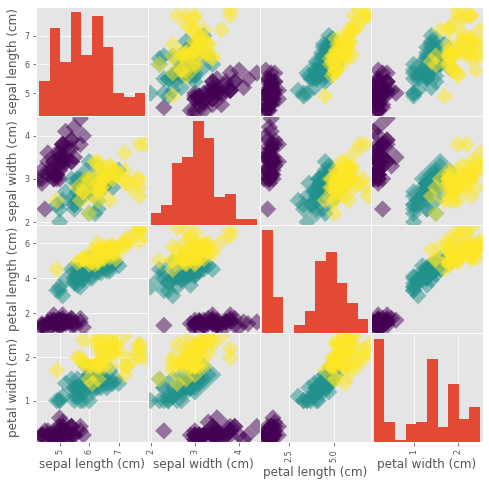

In [16]:
# visualize the data
_ = pd.plotting.scatter_matrix(df, c=y, figsize=[8,8], s=150, marker='D')

#### Iris k-NN Using sklearn

Use the k-NN algorithm on the iris dataset
- good basic algorithm for this problem
    - classification of labeled data

In [17]:
# create an instance of a k neighbors classifier
knn = KNeighborsClassifier(n_neighbors=7)

In [18]:
# train the data using the labeled dataset
# two arguments, features as numpy array, and the labels as an array
# array of labels must be 1d, the same length as the number of observations in the features array
# features must be continuous values for this method
# must be no missing values
knn.fit(iris['data'], iris['target'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [19]:
# generate some data for prediction
new_data = np.array([[5.0, 3.4, 1.5, 0.2], [7.8, 3.1 , 6.2, 2.4], [7., 3.1, 5.5, 2.2]])

In [20]:
# make predictions on unlabeled data
# new_array should have the same number of features in the same order as the training array
prediction = knn.predict(new_data)

In [21]:
# print the predictions
print('Prediction {}'.format(prediction))

Prediction [0 2 2]


In [22]:
# print the results as species names
[iris.target_names[prediction[i]] for i in range(len(prediction))]

['setosa', 'virginica', 'virginica']

This was run once on all of the training data
- There was no cross validation for the number of k to use
- There was no test data to evaluate the model

#### Measuring Model Performance
- accuracy = # correct predictions / total number of data points
- should use unseen data not used to train to test this
    - for production models divide the data into 60% train, 20% validation, 20% test
    - another option is cross validation, dividing the training data into folds, reiterating the model construction and k optimization each time (like below) and taking the average of the accuracy each time to choose the best k

This example only divides into train/test
- But this would be similar to the 4/5 fold test for cross validation as well

In [23]:
# use the sklearn test_train_split function to randomly split the data
# iris.data contains the feature measurements, iris.target contains the labels (y values)
# test_size specifies the proportion of the data to save for the test set, default is 25% test/75% train
# random_state just sets the seed for the random number generator
# stratify = y ensures that our labels are represented in train/test sets in the same proportion as the source data
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, 
                                                    random_state=21, stratify=iris.target)

In [24]:
# set the number of neighbors and create classifier instance
# train the model
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [25]:
# make the preditions on the test data
y_pred = knn.predict(x_test)

In [26]:
print(y_pred)

[2 1 2 2 1 0 1 0 0 1 0 2 0 2 2 0 0 0 1 0 2 2 2 0 1 1 1 0 0 1 2 2 0 0 1 2 2
 1 1 2 1 1 0 2 1]


In [27]:
# evaluate the model using the test features and the test labels
# do not supply the actual values from the .predict() method
knn.score(x_test, y_test)

0.9555555555555556

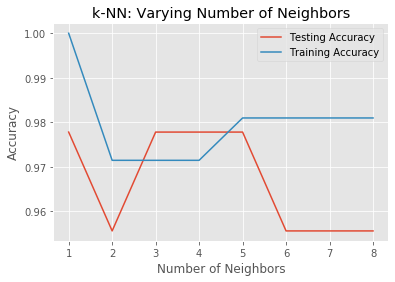

In [28]:
# Setup arrays to store train and test accuracies
# view the plot to help pick the best k to use
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(x_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(x_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(x_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Best k value is between 3-5

#### Hyperparameter Tuning for k Using GridSearchCV

- with multiple hyperparameters, this method will try all combinations of the hyperparameters (what you want)

In [29]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, 
                                                    random_state=21, stratify=iris.target)

In [30]:
# specify the grid of values to test
# multiple hyperparameters would each receive a key in the dictionary with its related range
param_grid = {'n_neighbors': np.arange(1, 50)}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)

knn_cv.fit(x_train, y_train)

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 3} 0.9714285714285714


#### Evaluating Model Performance with a Confusion Matrix

In [31]:
# assign data to variables
x = iris.data
y = iris.target
df = pd.DataFrame(x, columns=iris.feature_names)

In [32]:
# fit and train the model and predict on the test set

knn = KNeighborsClassifier(n_neighbors=5)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

In [33]:
# print the confusion matrix
# labels are 0, 1, 2
# predictions are columns
# observations are rows
# all correct, except that 1 was predicted as 1 that was actually a 2
print(confusion_matrix(y_test, y_pred))

[[23  0  0]
 [ 0 19  0]
 [ 0  1 17]]


In [34]:
# print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.95      1.00      0.97        19
           2       1.00      0.94      0.97        18

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



#### Logistic Regression for Classification

- Classifying binary decisions
    - 0 or 1
- Default threshold is 0.5
    - 0.5 or higher probability is classified as 1, while less is 0
- ROC curve (receiver operating characteristic)
    - trying all possible options for the threshold between 0-1
    - alters the number of true positives (y) plotted against false positives (x)
- AUC (area under the ROC curve)
    - if true positive = 1 and false positive = 0, that is the max area under the curve
    - the larger area under the curve, the better the model

- To use log_reg for multiple classes
    - `OneVsRestClassifier(LogisticRegression())` to create your model object

In [35]:
# Pima Indians diabetes data
diabetes = pd.read_csv('diabetes.csv')

In [36]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [37]:
# divide the data into features and target
# to simplify, only using one feature
x = diabetes.BMI.values
y = diabetes.Outcome.values
names = diabetes.drop('Outcome', axis=1).columns

x = x.reshape(-1,1)

In [38]:
# build, fit, and predict using the model

logreg = linear_model.LogisticRegression(solver='lbfgs')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

# compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[181  25]
 [ 81  21]]
              precision    recall  f1-score   support

           0       0.69      0.88      0.77       206
           1       0.46      0.21      0.28       102

    accuracy                           0.66       308
   macro avg       0.57      0.54      0.53       308
weighted avg       0.61      0.66      0.61       308



C:\Users\chuck.tucker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


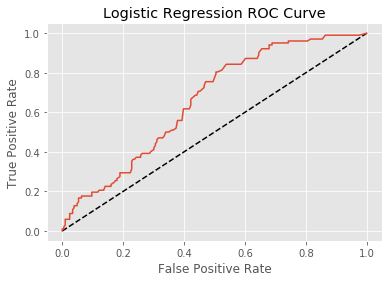

In [39]:
# plot ROC curve

# build the predicted probabilities
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = logreg.predict_proba(x_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Logistic Regression')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Logistic Regression ROC Curve')

In [40]:
# compute the AUC directly
print(roc_auc_score(y_test, y_pred_prob))

0.6582191128878737


In [41]:
# computing the AUC using cross validatoin
cv_scores = cross_val_score(logreg, x, y, cv=5, scoring='roc_auc')
print(cv_scores)
print(np.mean(cv_scores))

[0.6987963  0.67472222 0.68935185 0.74735849 0.63490566]
0.6890269042627533


C:\Users\chuck.tucker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chuck.tucker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chuck.tucker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chuck.tucker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\chuck.tucker\AppData\Local\Continuum\anacon

#### Hyperparameter Tuning Using GridSearchCV

- Logistic regression uses a hyperparameter C
    - C controls the inverse of the regularization strength
        - large C will overfit, while too small C will underfit

In [42]:
diabetes.Insulin.replace(0, np.nan, inplace=True)
diabetes.SkinThickness.replace(0, np.nan, inplace=True)
diabetes.BMI.replace(0, np.nan, inplace=True)
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               541 non-null float64
Insulin                     394 non-null float64
BMI                         757 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(4), int64(5)
memory usage: 54.1 KB


In [43]:
# using SimpleImputer, axis=0 means to calculate the mean of the column
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = diabetes.BMI.values
x = x.reshape(-1, 1)
imp.fit(x)
x = imp.transform(x)

In [44]:
# split the data
# divide the data into features and target
# to simplify, only using one feature
y = diabetes.Outcome.values
names = diabetes.drop('Outcome', axis=1).columns

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [45]:
# setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}


# create an instance of the model
logreg = linear_model.LogisticRegression(solver='liblinear')

# create an instance of the gridsearch object
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# fit the data
logreg_cv.fit(x_train, y_train)

# print the results
print(logreg_cv.best_params_, logreg_cv.best_score_)

{'C': 0.4393970560760795, 'penalty': 'l2'} 0.6739130434782609


In [46]:
logreg_test = linear_model.LogisticRegression(solver='liblinear', C=0.439, penalty='l2')

logreg_test.fit(x_train, y_train)

y_pred = logreg_test.predict(x_test)

# compute and print the confusion matrix and classification report
print(logreg_test.score(x_test, y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6655844155844156
[[187  19]
 [ 84  18]]
              precision    recall  f1-score   support

           0       0.69      0.91      0.78       206
           1       0.49      0.18      0.26       102

    accuracy                           0.67       308
   macro avg       0.59      0.54      0.52       308
weighted avg       0.62      0.67      0.61       308



Imputing using a pipeline and running the model all at once

In [47]:
x = diabetes.BMI.values
x = x.reshape(-1, 1)
y = diabetes.Outcome.values

In [48]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
logreg = linear_model.LogisticRegression(solver='lbfgs')
steps = [('imputation', imp), ('logistic_regression', logreg)]
pipeline = Pipeline(steps)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
pipeline.score(x_test, y_test)

C:\Users\chuck.tucker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6525974025974026

## Regression Example

#### splitting data to remove the target variables and convert to numpy array
```python
# separate variables
x = df.drop('Target_variable', axis=1).values
y = df.Target_variable.values

# may need to reshape single columns
x_one_feature = x[:,5]
x_one_feature.reshape(-1, 1)
y.reshape(-1, 1)
```

In [49]:
# load the boston housing dataset
boston = datasets.load_boston()

In [50]:
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


This shows what is in the Bunch object
- data
- target: target data
- target_names
- DESCR: description
- feature_names

In [51]:
# both datasets are numpy arrays
print(type(boston.data), type(boston.target))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [52]:
# 506 rows (samples) and 13 columns (features)
boston.data.shape, boston.target.shape

((506, 13), (506,))

In [53]:
# these are the median prices we are trying to predict
boston.target[0:5]

array([24. , 21.6, 34.7, 33.4, 36.2])

In [54]:
# assign data to variables
x = boston.data
y = boston.target
df = pd.DataFrame(x, columns=boston.feature_names)

In [55]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [56]:
# select only one feature for testing purposes
x_rooms = df.RM.values

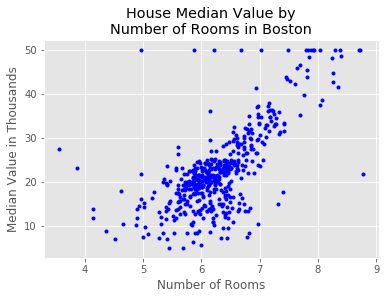

In [57]:
_ = plt.plot(x_rooms, y, marker='.', linestyle='None', color='blue')
_ = plt.xlabel('Number of Rooms')
_ = plt.ylabel('Median Value in Thousands')
_ = plt.title('House Median Value by\nNumber of Rooms in Boston')

In [58]:
# fit the regression model

# create an instance of LinearRegression object
reg = linear_model.LinearRegression()

# need to reshape the data to supply a 2d array
# use .reshape(-1, 1) if working with a 1d array
# changes from a simple array of numbers, to a column of numbers
x_rooms = x_rooms.reshape(-1, 1)
y = y.reshape(-1, 1)

# fit the model
reg.fit(x_rooms, y)

# create the prediction space between the min and max x values
prediction_space = np.linspace(min(x_rooms), max(x_rooms)).reshape(-1, 1)

In [59]:
# display the R^2 value
print('R-squared:', reg.score(x_rooms, y))

R-squared: 0.4835254559913343


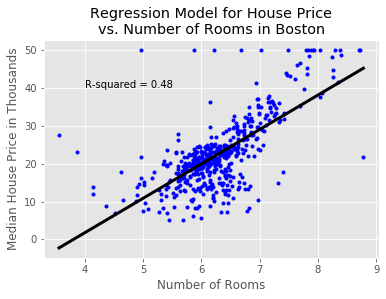

In [60]:
# plot the resulting regression model over the scatter plot

r2 = 'R-squared = ' + str(round(reg.score(x_rooms, y),2))

_ = plt.plot(x_rooms, y, marker='.', linestyle='None', color='blue')
_ = plt.plot(prediction_space, reg.predict(prediction_space), color='black', linewidth=3)
_ = plt.xlabel('Number of Rooms')
_ = plt.ylabel('Median House Price in Thousands')
_ = plt.title('Regression Model for House Price\nvs. Number of Rooms in Boston')
_ = plt.text(4, 40, r2)

In [61]:
# display the model parameters
print('coefficient: ', reg.coef_, 'intercept: ', reg.intercept_)

coefficient:  [[9.10210898]] intercept:  [-34.67062078]


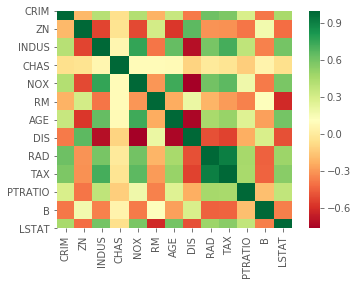

In [62]:
# view a heatmap to check for other variables that might explain some additional variation in y
# df.corr() computes pairwise correlations between the columns
# green means + correlation and red mean - correlation
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

This time, using all of the features from the Boston housing data
- normally, you would 'regularize' the data first, rather than just plug and play like this
    - regularization penalizes large coefficients for features
    - helps prevent overfitting
- example of this below

In [63]:
# divide the data into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# instantiate the regression object
reg_all = linear_model.LinearRegression()

# fit the model
reg_all.fit(x_train, y_train)

# assess the model
y_pred = reg_all.predict(x_test)

# compute r-squared for accuracy measure
rsquared = reg_all.score(x_test, y_test)

In [64]:
print(rsquared)

0.711226005748496


In [65]:
# view model params
# model params with coef exp of +1 or +00 have the largest effect
print(reg_all.coef_, reg_all.intercept_)

[[-1.33470103e-01  3.58089136e-02  4.95226452e-02  3.11983512e+00
  -1.54170609e+01  4.05719923e+00 -1.08208352e-02 -1.38599824e+00
   2.42727340e-01 -8.70223437e-03 -9.10685208e-01  1.17941159e-02
  -5.47113313e-01]] [31.63108404]


In [66]:
pd.DataFrame({'features': np.array(boston.feature_names), 'estimatedCoefficients': reg_all.coef_[0]})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.133470
1,ZN,0.035809
2,INDUS,0.049523
3,CHAS,3.119835
4,NOX,-15.417061
5,RM,4.057199
6,AGE,-0.010821
7,DIS,-1.385998
8,RAD,0.242727
9,TAX,-0.008702


#### Cross Validation for Linear Regression Using scikit-learn
- Boston housing dataset

In [67]:
# assign data to variables

# features
x = boston.data

# target
y = boston.target

# instantiate the model
reg = linear_model.LinearRegression()

# do the cross validation with cv=5 for 5-fold validation
# returns an array of cross validation scores of length 'cv'
# r-squared is reported as this is the default for linear regression
cv_results = cross_val_score(reg, x, y, cv=5)

print(cv_results)
print(np.mean(cv_results))

[ 0.63919994  0.71386698  0.58702344  0.07923081 -0.25294154]
0.3532759243958772


#### Linear Regression with Regularization

- Ridge Regression
    - loss function is OLS + the sum of the squared features coefficients times a hyperparameter (alpha or lambda depending on who you ask)
    - must choose an alpha, similar to how k is chosen for k-NN
    - 0 for alpha/lambda returns OLS and can lead to overfitting, and very high alpha overpenalizes leading to an extremely simple model that underfits

In [68]:
# divide the data into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# choose alpha value
# normalize=True ensures variables are on the same scale (divide by variances?)
ridge = linear_model.Ridge(alpha=0.1, normalize=True)
ridge.fit(x_train, y_train)
ridge_pred = ridge.predict(x_test)
print(ridge.score(x_test, y_test))

0.6996938275127313


Ridge Regression to Select alpha from DataCamp

In [69]:
# ridge regression to select alpha

def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

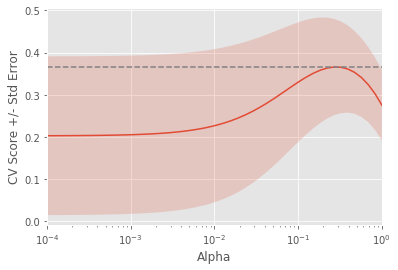

In [70]:
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = linear_model.Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, x, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

Hyperparameter tuning to get alpha using GridSearchCV
- Not sure if the first instance of ridge should use normalize=True or not

In [71]:
# divide the data into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# specify the grid of values to test
# multiple hyperparameters would each receive a key in the dictionary with its related range
param_grid = {'alpha': np.arange(0, 1, 0.01)}

ridge = linear_model.Ridge()

ridge_cv = GridSearchCV(ridge, param_grid, cv=5)

ridge_cv.fit(x_train, y_train)

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(ridge_cv.best_params_, ridge_cv.best_score_)

{'alpha': 0.0} 0.6880930139238904


In [72]:
# choose alpha value
# normalize=True ensures variables are on the same scale (divide by variances?)
ridge = linear_model.Ridge(alpha=0.99, normalize=True)
ridge.fit(x_train, y_train)
ridge_pred = ridge.predict(x_test)
print(ridge.score(x_test, y_test))

0.6249053531380654


- Lasso Regression
    - loss function is OLS + sum of the absolute values of the feature coefficients times the hyperparameter alpha/lambda
    - less overall penalty for large feature coefficients
    - **helps with features selection**
        - tends to shrink coefficients of less important features to exactly 0 (dimension reduction)

In [73]:
# divide the data into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# choose alpha value
# normalize=True ensures variables are on the same scale (divide by variances?)
lasso = linear_model.Lasso(alpha=0.1, normalize=True)
lasso.fit(x_train, y_train)
lasso_pred = lasso.predict(x_test)
print(lasso.score(x_test, y_test))

0.5950229535328551


- Feature Selection with Lasso Regression
    - be sure to include normalize=True
- Choose only features with coefficients that are not 0

[-0.          0.         -0.          0.         -0.          2.95469455
 -0.          0.         -0.         -0.         -0.24795837  0.
 -0.42817439]


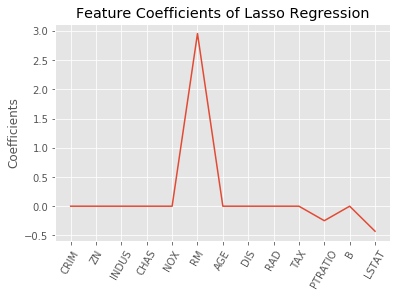

In [74]:
# assign data to variables
x = boston.data
y = boston.target
df = pd.DataFrame(x, columns=boston.feature_names)

# extract feature names omitting the target
names = df.columns

lasso = linear_model.Lasso(alpha=0.1, normalize=True)

# extract the .coef_ attribute from the model
lasso_coef = lasso.fit(x, y).coef_

print(lasso_coef)

_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
_ = plt.title('Feature Coefficients of Lasso Regression')

## NLP Basics
- Strategies
    - Bag of Words
        - use each word individually and count the number of appearances as the features
    - N-grams
        - use combinations of words as features
        - 2-grams uses every combination of adjacent 2-words
            - 'This movie was very horrible and I hated it.'
                - 'This movie', 'movie was', 'was very', 'very horrible', 'horrible and', 'and I', 'I hated', 'hated it'
- Create your vocabulary
    - `vectorizer_object.fit(text_feature_data)`
- Tips/Tricks
    - tokenize on punctuation to avoid hyphens/underscores etc. if present (could help)
        - `CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)`
    - include uni-grams and bi-grams in the model
        - `CountVectorizer(ngram_range=(1,2))`
    - include interactions (can be used with non-text data too)
        - `interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)`
            - can add whatever degree you want, but 2 is the interaction between 2 features (at a time)
    - use `HashingVectorizer` instead of `CountVectorizer`
        - needs extra args for straight replace `norm=None, non_negative=True`
- Vectorize the text (turn it into a vector of 1's (appearance) and 0's (non appearance))
    ```python
    # using a pipeline and bag of words
    X_train, y_train, X_test, y_test = train_test_split(df.text_column, pd.get_dummies(df.y_values), test_size=0.25)
    
    pl = Pipeline([
                   ('vec', Vectorizer()),
                   ('clf', OneVsRestClassifier(LogisticRegresssion())
                 )]
        
    pl.fit(X_train, y_train)
    pl.score(X_test, y_test)
    ```

- Using HashingVectorizer

```python
# Import HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Get text data: text_data
text_data = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)' 

# Instantiate the HashingVectorizer: hashing_vec
# can drop this into a pipeline ('vec', HashingVectorizer...)
hashing_vec = HashingVectorizer(norm=None, non_negative=True, token_pattern=TOKENS_ALPHANUMERIC, ngram_range(1,2))

# Fit and transform the Hashing Vectorizer
hashed_text = hashing_vec.fit_transform(text_data)
```

## Working with Text and Numeric Data in One Model
- Strategy
    - split the train/test data
    - get text data and numeric data separately using FunctionTransformer()
    - can combine all text columns into a single column
    - create separate pipelines
    - combine the data using FeatureUnion()

#### Numeric/text data example
```python

# validate=False tells sklearn not to check for NaN's or validate the dtypes

# lambda function is just getting the 'text' column from the 'x' dataframe passed
# this can be called independently with a df as an arg or passed to a pipeline
# if calling independently use get_text_data.fit_transform(df)
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

# lambda function is just getting the columns 'num1' and 'num2' from the 'x' dataframe passed
# this can be called independently with a df as an arg or passed to a pipeline
# if calling independently use get_numeric_data.fit_transform(df)
get_numeric_data = FunctionTransformer(lambda: x: x[['num1', 'num2']], validate=False)

# create the separate pipelines using your function transformers
numeric_pipeline = Pipeline([
                             ('selector', get_numeric_data),
                             ('imputer', SimpleImputer())
                           ])

text_pipeline = Pipeline([
                             ('selector', get_text_data),
                             ('vectorizer', CountVectorizer())
                           ])

# combin the text and numeric data features
union = FeatureUnion([
                      ('numeric', numeric_pipeline),
                      ('text', text_pipeline)
                    ])

# create the union pipeline
pl = Pipeline([
                ('union', FeatureUnion([
                                        ('numeric', numeric_pipeline),
                                        ('text', text_pipeline)
                                       ])),
                ('clf', OneVsRestClassifier(LogisticRegression()))
             ])

# fit the data
pl.fit(X_train, y_train)

# get the accuracy
pl.score(X_test, y_test)
```

## Unsupervised Learning

### K-Means Clustering

In [75]:
# load iris data
iris = datasets.load_iris()

# assign data to variables
x = iris.data
y = iris.target
df = pd.DataFrame(x, columns=iris.feature_names)

In [76]:
print(type(x), x.shape)

<class 'numpy.ndarray'> (150, 4)


In [77]:
# build the model
model = KMeans(n_clusters=3)

# fit the model
model.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [78]:
# predict using the model on the same data used to train
pred = model.predict(x)

# assign the centroids to variables
centroids = model.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,2]

In [79]:
# can assign labels based on this model by feeding a new array with 4 columns to model.predict(new_data)

# should use StandardScaler for KMeans if the features don't have equal variances/ranges

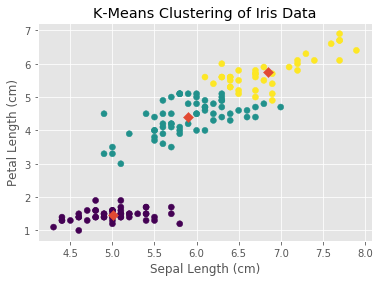

In [80]:
# visualize the clusters using 2 of the 4 features
xs = x[:,0]   # get the first column
ys = x[:,2]   # get the third column


# build the plot with the scatter of the data and include cluster centers (centroids)
_ = plt.scatter(xs, ys, c=pred)
_ = plt.scatter(centroids_x, centroids_y, marker='D', s=50)
_ = plt.title('K-Means Clustering of Iris Data')
_ = plt.xlabel('Sepal Length (cm)')
_ = plt.ylabel('Petal Length (cm)')

In [81]:
# evaluate the model

# display the inertia (measure involving spread of clusters/distance of points from centroid)
print('Model Inertia: {}'.format(model.inertia_))

Model Inertia: 78.85144142614601


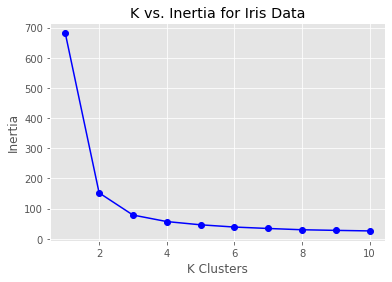

In [82]:
# evaluating the inertia for different k choices
# elbox method for choosing the best k
ks = []
ins = []

for i in range(10):
    # start at 1
    k = i + 1
    
    # build the model
    model = KMeans(n_clusters=k)

    # fit the model
    model.fit(x)
    
    # store the results
    ks.append(k)
    ins.append(model.inertia_)

inerts = pd.DataFrame({'k': ks, 'inertia': ins})

_ = plt.plot(inerts.k, inerts.inertia, marker='o', color='b')
_ = plt.title('K vs. Inertia for Iris Data')
_ = plt.xlabel('K Clusters')
_ = plt.ylabel('Inertia')

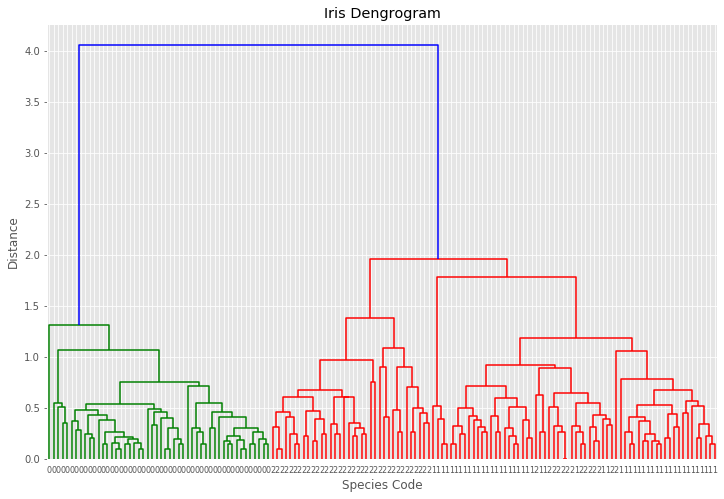

In [83]:
# using hierarchical clustering on iris data
mergings = linkage(x, method='average')

_ = plt.figure(figsize=(12,8))
_ = dendrogram(mergings, labels=y, leaf_rotation=0, leaf_font_size=8)
_ = plt.title('Iris Dengrogram')
_ = plt.xlabel('Species Code')
_ = plt.ylabel('Distance')

In [84]:
# store the cluster assignments and compare to the species codes
labels = fcluster(mergings, 0.3, criterion='distance')

check = pd.DataFrame({'labels': labels, 'species_code': y})
check.sort_values('labels', inplace=True)

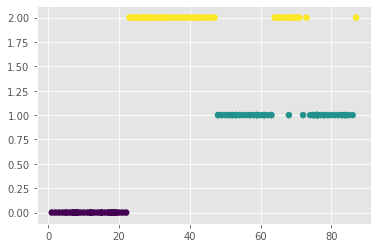

In [85]:
# visualize the results
# the 0 cluster came out well
# 1 and 2 were kinda mixed, as evident on the dengrogram
_ = plt.scatter(check.labels, check.species_code, c=check.species_code)

## t-SNE for Visualizing High Dimensional Data in 2-d

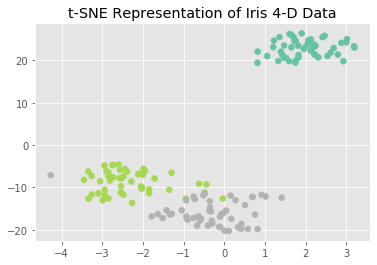

In [86]:
# t-SNE with the 4-d iris data

# good learning rate choices are usually between 50 and 200
# trial and error to get a good one
model = TSNE(learning_rate=100)

# fit transform the data
transformed = model.fit_transform(x)

# create x/y for scatter plot
xs = transformed[:,0]
ys = transformed[:,1]

# create the plot
# axis values/scales are not really interpretable
_ = plt.scatter(xs, ys, c=y, cmap='Set2')
_ = plt.title('t-SNE Representation of Iris 4-D Data')

#### Principal Component Analysis (PCA) on Iris Data
- Generate PCA Features
    - create PCA object
    - cit and transform to the sample data
    - you can view the components (no dimension reduction yet)
- To Find Principal Components
    - these are the components with significant variance (intrinsic dimension)

In [87]:
# create PCA instance
# can specify n_components for PCA objects, and want to use the intrinsic dimension of the data if known
# this is necessary for dimension reduction, otherwise you will get the same number of features as the data
pca = PCA()

# fit on sample data
pca.fit(x)

# can use to transform sample data or test/unseen data
x_pca = pca.transform(x)

# this new transformed array still has the same number of features as the original data
# the rows are still observations and the columns are now the transformed PCA features
# pca features are not correlated even if the original features were

# components_ attribute of a pca transform object will provide the principal components
# returns a numpy array with one row for each component
print(pca.components_)

[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]
 [-0.31548719  0.3197231   0.47983899 -0.75365743]]


In [88]:
# the explained variance of each feature is contained in the explained_variance_ attribute
# only features above a chosen threshold are used for the principal components
print(pca.explained_variance_)

[4.22824171 0.24267075 0.0782095  0.02383509]


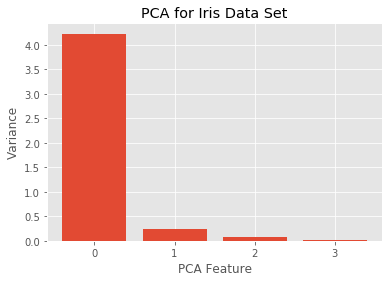

In [89]:
# plot the variances of the PCA features

# create range enumerating the pca features
features = range(pca.n_components_)

# make a bar plot of variances
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xticks(features)
_ = plt.xlabel('PCA Feature')
_ = plt.ylabel('Variance')
_ = plt.title('PCA for Iris Data Set')

This plot shows that the intrinsic dimension for iris data is really 1

In [90]:
y2 = pd.DataFrame({'species': y})

In [91]:
species = y2.species.map({0: 'blue', 1: 'red', 2: 'green'})

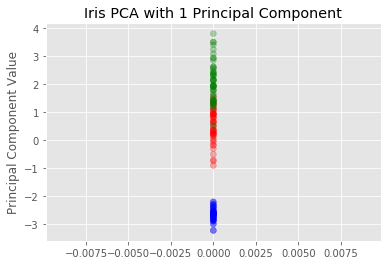

In [92]:
# reducing the dimension of the iris data to 1 (intrinsic dimension)
model = PCA(n_components=1)

transformed = model.fit_transform(x)

xs = np.zeros(transformed.shape)

_ = plt.scatter(xs, transformed, c=species, cmap='Set2', alpha=0.3)
_ = plt.ylabel('Principal Component Value')
_ = plt.title('Iris PCA with 1 Principal Component')

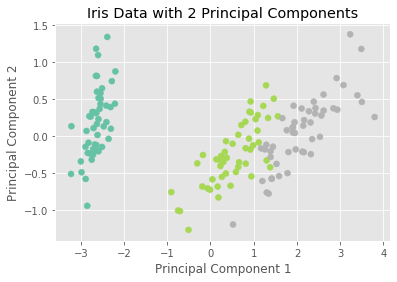

In [93]:
# same analysis using 2 PC's

model = PCA(n_components=2)

transformed = model.fit_transform(x)

xs = transformed[:,0]
ys = transformed[:,1]

_ = plt.scatter(xs, ys, c=y, cmap='Set2')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 2')
_ = plt.title('Iris Data with 2 Principal Components')

#### Sparse Arrays and PCA
- use `TruncatedSVD()` instead of `PCA()`
    - specify the `n_components` the same way as PCA
    - other syntax for fitting/transforming is the same

#### Dimension Reduction Using Non-negative Matrix Factorization (NMF)
- works on sparse arrays and regular arrays
- same basic syntax as PCA(), but you must specify n_components

In [94]:
# using rotten tomatoes dataset
critics = pd.read_csv('../Springboard_Portfolio/9_ML_Naive_Bayes/critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [95]:
# create the feature data and labels
tfidf = TfidfVectorizer(min_df=1, stop_words='english')
X = tfidf.fit_transform(critics.quote)
X = X.tocsc()  # some versions of sklearn return COO format
y = (critics.fresh == 'fresh').values.astype(np.int)

In [96]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=21, stratify=y)

In [97]:
# fit the NMF model using the training data
model = NMF(n_components=50)
model.fit(X_train)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [98]:
# transform the data using NMF
nmf_features = model.transform(X_train)

#### Build a recommender series based on similarities in text

In [127]:
# calculate cosine similarities
norm_features = normalize(nmf_features)

# create dataframe of the features, could add labels as an index if you have them
df = pd.DataFrame(norm_features)

In [128]:
# build similarity index for one entry
current_review = df.iloc[0]
similarities = df.dot(current_review)

In [129]:
# print the indexes and cosine similarities for the largest similarities
# this can be used to build a recommender system based on similarities in text
print(similarities.nlargest())

0        1.000000
9741     0.979001
1231     0.978443
10197    0.977042
489      0.975257
dtype: float64


Trying to run a Naive Bayes model based on this, but I'm not sure that this works

In [99]:
# build a Naive Bayes model using just the training data
clf = MultinomialNB(alpha=1)
clf.fit(nmf_features, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [100]:
# print the accuracy on the training and test data
print(clf.score(nmf_features, y_train))
print(clf.score(model.transform(X_test), y_test))

0.6093463092177746
0.6093381880488328
